# SVM

In [1]:
import numpy as np
import pickle
import bz2
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD


In [2]:
# load training data
Xtr_loadpath = 'Xtr.csv'
Xts_loadpath = 'Xts.csv'
ytr_loadpath = 'ytr.csv'


Xtr = np.loadtxt(Xtr_loadpath, delimiter=",")
Xts = np.loadtxt(Xts_loadpath, delimiter=",")
ytr = np.loadtxt(ytr_loadpath, delimiter=",")

num_features = Xtr.shape[1]
num_samples = Xtr.shape[0]
print(num_features)
print(num_samples)



16
10000


In [3]:
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

# Assuming X is your dataset
#normalizer = Normalizer()
#X_normalized = normalizer.fit_transform(Xtr)
#scaler = MinMaxScaler()
#X_scaled = scaler.fit_transform(X)

scaler=StandardScaler()
xmean=np.mean(Xtr,axis=0)
xstd=np.std(Xtr,axis=0)
Xtr_standardized = (Xtr-xmean[None,:])/xstd[None,:]
Xts_standardized = (Xts-xmean[None,:])/xstd[None,:]
#Xtr_standardized=scaler.fit_transform(Xtr)
#Xts_standardized=scaler.fit_transform(Xts)



# save the standardized training data
Xtr_savepath = 'Xtr_sklearn.csv'
Xts_savepath = 'Xts_sklearn.csv'
yts_hat_savepath = 'yts_hat_sklearn.csv'

np.savetxt(Xtr_savepath, Xtr_standardized, delimiter=",")
np.savetxt(Xts_savepath, Xts_standardized, delimiter=",")

X_train, X_test, y_train, y_test = train_test_split(Xtr_standardized, ytr, test_size=0.20, shuffle=True)

In [4]:
from sklearn import svm

# TODO:  Create a classifier: a support vector classifier
svc_n = svm.LinearSVC(penalty='l1',C=100, multi_class='ovr',max_iter=10000,loss='squared_hinge',dual=False)
svc_n.fit(X_train,y_train)
yhat_ts_n = svc_n.predict(X_test)
acc_ts_n = np.mean(yhat_ts_n== y_test)
print('Accuracy on test data = {0:f}'.format(acc_ts_n))

Accuracy on test data = 0.699000


In [5]:
svc_c = svm.LinearSVC(C=10, multi_class='crammer_singer',max_iter=100000,loss='squared_hinge')
svc_c.fit(X_train,y_train)
yhat_ts_c = svc_c.predict(X_test)
acc_ts_c = np.mean(yhat_ts_c== y_test)
print('Accuracy on test data = {0:f}'.format(acc_ts_c))


Accuracy on test data = 0.787500


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [6]:
from sklearn.model_selection import PredefinedSplit

#C_test = [0.1, 1, 10,100]
#gam_test = [0.001, 0.01, 0.1]
C_test = [0.001, 0.01, 0.1, 1, 10, 100]
gam_test = [0.0001, 0.001, 0.01, 0.1, 1, 10]
num_splits=5
kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)
svc_rb = svm.SVC(kernel="sigmoid", C=0.01, gamma=1, verbose=0)
parameters={'C':C_test,'gamma':gam_test,'kernel':['sigmoid']}
gscv = GridSearchCV(svc_rb,cv=kf,param_grid=parameters,verbose=0,n_jobs=-1)
gscv.fit(X_train,y_train)

# TODO:  Print the best parameter and score of the classifier
print(f'Best Param = {gscv.best_params_}')
print(f'Best score = {gscv.best_score_}')
#print(gscv.best_params_['C'])
#print(gscv.best_params_['gamma'])
svc_rb = svm.SVC(kernel="sigmoid", C=gscv.best_params_['C'], gamma=gscv.best_params_['gamma'], verbose=0)
svc_rb.fit(X_train,y_train)
yhat_ts = svc_rb.predict(X_test)
acc_ts = np.mean(yhat_ts== y_test)
print('Accuracy = {0:f}'.format(acc_ts))


Best Param = {'C': 100, 'gamma': 0.001, 'kernel': 'sigmoid'}
Best score = 0.82775
Accuracy = 0.838500


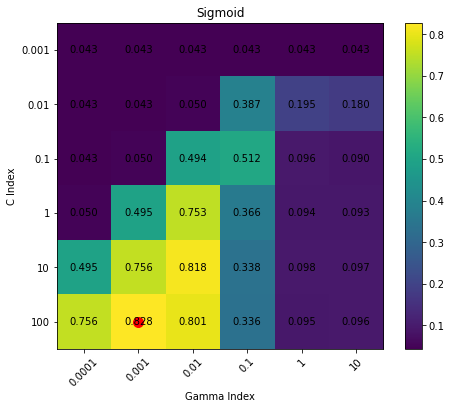

In [7]:

mean_test_scores = np.array(gscv.cv_results_['mean_test_score']).reshape(len(C_test), len(gam_test))

# Plotting the heatmap with a different colormap ('viridis')
plt.figure(figsize=(8, 6))
heatmap = plt.imshow(mean_test_scores, interpolation='nearest', cmap='viridis')  # Use 'viridis' colormap
plt.xlabel('Gamma Index')
plt.ylabel('C Index')
plt.colorbar()

# Add text annotations for each cell
for i in range(len(C_test)):
    for j in range(len(gam_test)):
        plt.text(j, i, f'{mean_test_scores[i, j]:.3f}', ha='center', va='center', color='black')

plt.xticks(np.arange(len(gam_test)), gam_test, rotation=45)
plt.yticks(np.arange(len(C_test)), C_test)
plt.title('Sigmoid')
best_index = np.unravel_index(np.argmax(mean_test_scores), mean_test_scores.shape)
plt.scatter(best_index[1], best_index[0], marker='o', color='red', s=100, label='Best Score')
plt.savefig('Figures/Sigmoid.pdf')


In [8]:
# TODO:  Create a pre-defined test split object 
from sklearn.model_selection import PredefinedSplit

num_total_samples = len(X_train)+len(X_test)
test_fold = np.full(num_total_samples, -1)
test_fold[len(X_test):] = 0
x = np.vstack((X_train,X_test))
y = np.hstack((y_train,y_test))
ps = PredefinedSplit(test_fold)
print((test_fold))

ps = PredefinedSplit(test_fold)
#kf = KFold(...)

#C_test = [0.1, 1, 10,100]
#gam_test = [0.001, 0.01, 0.1]
C_test = [0.001, 0.01, 0.1, 1, 10]
gam_test = [0.0001, 0.001, 0.01, 0.1, 1, 10]
svc_rb = svm.SVC(kernel="poly", C=0.01, gamma=1, verbose=0)

parameters={'C':C_test,'gamma':gam_test,'kernel':['poly']}
gscv = GridSearchCV(svc_rb,cv=ps,param_grid=parameters,verbose=0)
gscv.fit(x,y)

# TODO:  Print the best parameter and score of the classifier
print(f'Best Param = {gscv.best_params_}')
print(f'Best score = {gscv.best_score_}')
#print(gscv.best_params_['C'])
#print(gscv.best_params_['gamma'])
svc_rb = svm.SVC(kernel="poly", C=gscv.best_params_['C'], gamma=gscv.best_params_['gamma'], verbose=0)
svc_rb.fit(X_train,y_train)
yhat_ts = svc_rb.predict(X_test)
acc_ts = np.mean(yhat_ts== y_test)
print('Accuracy = {0:f}'.format(acc_ts))


[-1 -1 -1 ...  0  0  0]
Best Param = {'C': 0.01, 'gamma': 1, 'kernel': 'poly'}
Best score = 0.83325
Accuracy = 0.940000


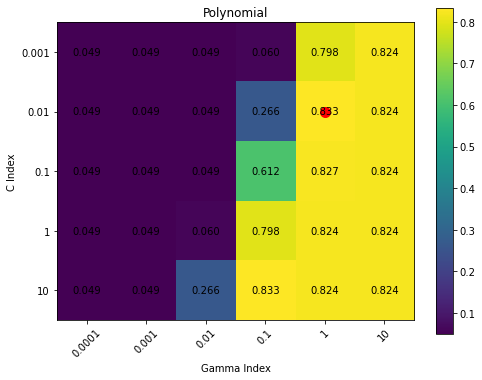

In [9]:

mean_test_scores = np.array(gscv.cv_results_['mean_test_score']).reshape(len(C_test), len(gam_test))

# Plotting the heatmap with a different colormap ('viridis')
plt.figure(figsize=(8, 6))
heatmap = plt.imshow(mean_test_scores, interpolation='nearest', cmap='viridis')  # Use 'viridis' colormap
plt.xlabel('Gamma Index')
plt.ylabel('C Index')
plt.colorbar()

# Add text annotations for each cell
for i in range(len(C_test)):
    for j in range(len(gam_test)):
        plt.text(j, i, f'{mean_test_scores[i, j]:.3f}', ha='center', va='center', color='black')

plt.xticks(np.arange(len(gam_test)), gam_test, rotation=45)
plt.yticks(np.arange(len(C_test)), C_test)
plt.title('Polynomial')
best_index = np.unravel_index(np.argmax(mean_test_scores), mean_test_scores.shape)
plt.scatter(best_index[1], best_index[0], marker='o', color='red', s=100, label='Best Score')
plt.savefig('Figures/Polynomial.pdf')


In [10]:
# TODO:  Create a pre-defined test split object 
from sklearn.model_selection import PredefinedSplit

kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)
test_accuracies = []
C_test = [0.01, 0.01, 0.1, 1, 10]
gam_test = [0.01, 0.001, 0.01, 0.1, 1, 2]
parameters={'C':C_test,'gamma':gam_test,'kernel':['linear']}
gscv = GridSearchCV(svc_rb,cv=kf,param_grid=parameters,verbose=0,n_jobs=-1)
gscv.fit(X_train,y_train)

# TODO:  Print the best parameter and score of the classifier
print(f'Best Param = {gscv.best_params_}')
print(f'Best score = {gscv.best_score_}')
#print(gscv.best_params_['C'])
#print(gscv.best_params_['gamma'])
svc_rb = svm.SVC(kernel="linear", C=gscv.best_params_['C'], gamma=gscv.best_params_['gamma'], verbose=0)
svc_rb.fit(X_train,y_train)
yhat_ts = svc_rb.predict(X_test)
acc_ts = np.mean(yhat_ts== y_test)
print('Accuracy = {0:f}'.format(acc_ts))


Best Param = {'C': 1, 'gamma': 0.01, 'kernel': 'linear'}
Best score = 0.8428749999999999
Accuracy = 0.852000


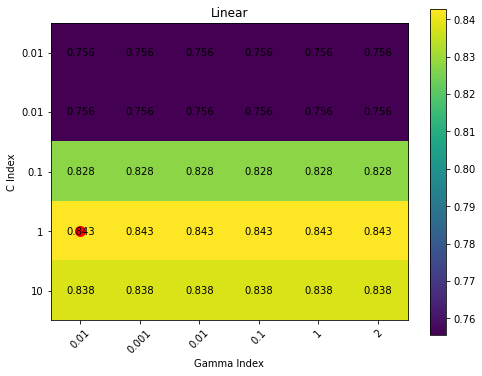

In [11]:

mean_test_scores = np.array(gscv.cv_results_['mean_test_score']).reshape(len(C_test), len(gam_test))

# Plotting the heatmap with a different colormap ('viridis')
plt.figure(figsize=(8, 6))
heatmap = plt.imshow(mean_test_scores, interpolation='nearest', cmap='viridis')  # Use 'viridis' colormap
plt.xlabel('Gamma Index')
plt.ylabel('C Index')
plt.colorbar()

# Add text annotations for each cell
for i in range(len(C_test)):
    for j in range(len(gam_test)):
        plt.text(j, i, f'{mean_test_scores[i, j]:.3f}', ha='center', va='center', color='black')

plt.xticks(np.arange(len(gam_test)), gam_test, rotation=45)
plt.yticks(np.arange(len(C_test)), C_test)
plt.title('Linear')
best_index = np.unravel_index(np.argmax(mean_test_scores), mean_test_scores.shape)
plt.scatter(best_index[1], best_index[0], marker='o', color='red', s=100, label='Best Score')
plt.savefig('Figures/Linear.pdf')


In [12]:
from sklearn.model_selection import PredefinedSplit

num_total_samples = len(X_train)+len(X_test)
test_fold = np.full(num_total_samples, -1)
test_fold[len(X_test):] = 0
x = np.vstack((X_train,X_test))
y = np.hstack((y_train,y_test))
ps = PredefinedSplit(test_fold)
print((test_fold))

ps = PredefinedSplit(test_fold)
#kf = KFold(...)

#C_test = [0.1, 1, 10,100]
#gam_test = [0.001, 0.01, 0.1]
C_test = [0.001, 0.01, 0.1, 1, 10, 100]
gam_test = [0.0001, 0.001, 0.01, 0.1, 1, 10]
svc_rb = svm.SVC(kernel="rbf", C=0.01, gamma=1, verbose=0)
parameters={'C':C_test,'gamma':gam_test,'kernel':['rbf']}
gscv = GridSearchCV(svc_rb,cv=ps,param_grid=parameters,verbose=0,n_jobs=-1)
gscv.fit(x,y)

# TODO:  Print the best parameter and score of the classifier
print(f'Best score = {gscv.best_params_}')
print(f'Best Param = {gscv.best_score_}')


[-1 -1 -1 ...  0  0  0]


Best score = {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best Param = 0.8905


In [13]:
num_splits = 5  # Adjust as needed

# Create KFold object
kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)
test_accuracies = []
C_test = [0.01, 0.01, 0.1, 1, 10,13.5]
gam_test = [0.01, 0.001, 0.01, 0.1, 1]
parameters={'C':C_test,'gamma':gam_test,'kernel':['rbf']}
gscv = GridSearchCV(svc_rb,cv=kf,param_grid=parameters,verbose=0,n_jobs=-1)
gscv.fit(X_train,y_train)
print(f'Best score = {gscv.best_params_}')
print(f'Best Param = {gscv.best_score_}')


Best score = {'C': 13.5, 'gamma': 0.1, 'kernel': 'rbf'}
Best Param = 0.952375


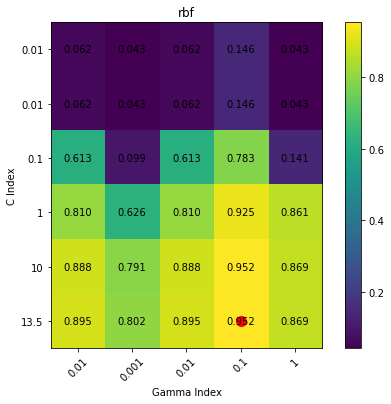

In [14]:

mean_test_scores = np.array(gscv.cv_results_['mean_test_score']).reshape(len(C_test), len(gam_test))

# Plotting the heatmap with a different colormap ('viridis')
plt.figure(figsize=(8, 6))
heatmap = plt.imshow(mean_test_scores, interpolation='nearest', cmap='viridis')  # Use 'viridis' colormap
plt.xlabel('Gamma Index')
plt.ylabel('C Index')
plt.colorbar()

# Add text annotations for each cell
for i in range(len(C_test)):
    for j in range(len(gam_test)):
        plt.text(j, i, f'{mean_test_scores[i, j]:.3f}', ha='center', va='center', color='black')

plt.xticks(np.arange(len(gam_test)), gam_test, rotation=45)
plt.yticks(np.arange(len(C_test)), C_test)
plt.title('rbf')
best_index = np.unravel_index(np.argmax(mean_test_scores), mean_test_scores.shape)
plt.scatter(best_index[1], best_index[0], marker='o', color='red', s=100, label='Best Score')
plt.savefig('Figures/MeanTestAccuracy.pdf')


In [15]:
num_splits = 5  # Adjust as needed

# Create KFold object
kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)
test_accuracies = []
C_test = np.linspace(9,20,25)
gam_test=np.linspace(0.1,1,20)
parameters={'C':C_test,'gamma':gam_test,'kernel':['rbf']}
gscv = GridSearchCV(svc_rb,cv=kf,param_grid=parameters,verbose=0,n_jobs=-1)
gscv.fit(X_train,y_train)
print(f'Best score = {gscv.best_params_}')
print(f'Best Param = {gscv.best_score_}')


Best score = {'C': 16.791666666666664, 'gamma': 0.1, 'kernel': 'rbf'}
Best Param = 0.953125


In [26]:
print(gscv.best_params_['C'])
print(gscv.best_params_['gamma'])
print(f'Best Param = {gscv.best_score_}')
svc_rb = svm.SVC(kernel="rbf",C=gscv.best_params_['C'], gamma=gscv.best_params_['gamma'],verbose=0)
svc_rb.fit(X_train,y_train)
yhat_ts = svc_rb.predict(X_test)
acc_ts = np.mean(yhat_ts== y_test)
print('Accuracy = {0:f}'.format(acc_ts))



16.791666666666664
0.1
Best Param = 0.953125
Accuracy = 0.962000
Accuracy = 0.962000
Accuracy = 0.963000
Accuracy = 0.963000
Accuracy = 0.962500
Accuracy = 0.962000
Accuracy = 0.962000


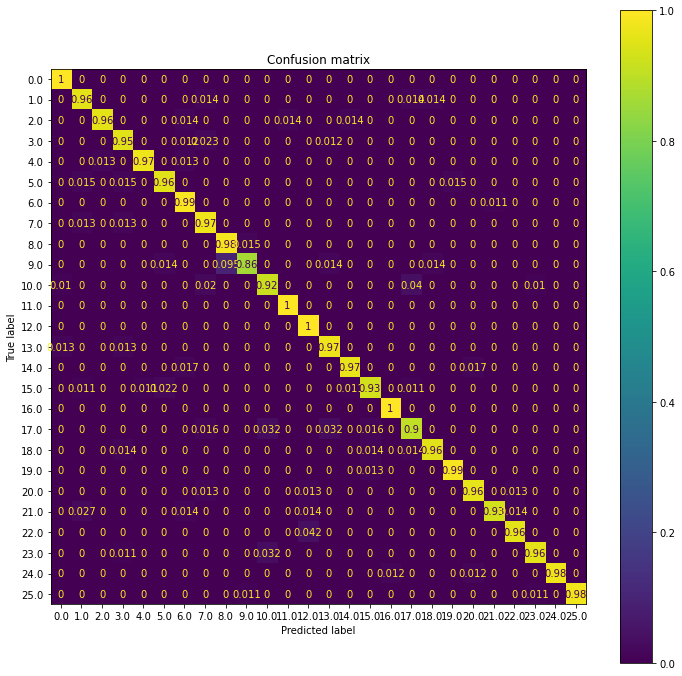

In [17]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(12, 12))
svc_rb = svm.SVC(kernel="rbf",C=gscv.best_params_['C'], gamma=gscv.best_params_['gamma'],verbose=0)
svc_rb.fit(X_train, y_train)
plot_confusion_matrix(svc_rb, X_test, y_test, ax=ax,normalize='true')
plt.title('Confusion matrix')
plt.savefig('Figures/Confusionmatrix.pdf')

In [18]:

model_savepath = 'model.bz2'
with bz2.BZ2File(model_savepath, 'w') as f:
    pickle.dump(svc_rb,f)

In [19]:
# generate kaggle submission file using the validation script
!python {"validation.py " + model_savepath + " --Xts_path " + Xts_savepath + " --Xtr_path " + Xtr_savepath + " --yts_hat_path " + yts_hat_savepath } 

'python3' is not recognized as an internal or external command,
operable program or batch file.
